<a href="https://colab.research.google.com/github/hellocybernetics/Tensorflow-Probability-Tutorials/blob/master/salary_modeling_edward2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-probability

In [0]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
from scipy.stats import mstats
%matplotlib inline

In [0]:
tfd = tfp.distributions
tfe = tf.contrib.eager
ed = tfp.edward2

tf.enable_eager_execution()

In [0]:
N = 200
K = 4

def get_data():
    
    a0 = 350.
    b0 = 20.
    s_a = 40.
    s_b = 5.
    s_Y = 30.

    
    a = np.random.normal(loc=a0, scale=s_a, size=(K,))
    b = np.random.normal(loc=b0, scale=s_b, size=(K,))
    
    KID = []
    X = []
    Y = []
    
    for n in range(N):
        kid = np.random.randint(0, K, 1)
        KID.append(int(kid))
        
        x = np.random.randint(22, 45, 1)
        X.append(x)
        
        Y.append(np.random.normal(loc=a[kid]+b[kid]*(x-22), scale=s_Y))

    return (np.array(X).reshape(N, 1).astype(np.float32), 
            np.array(Y).reshape(N, 1), 
            np.array(KID).reshape(N, 1).astype(np.int32))

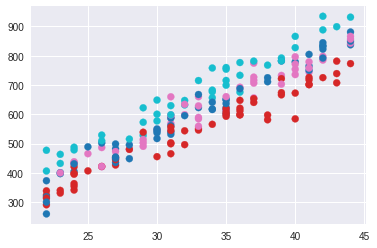

In [5]:
X_data, Y_data, KID_data = get_data()
plt.scatter(X_data, Y_data, c=KID_data, cmap='tab10')

In [0]:
df = pd.DataFrame(np.hstack([X_data, Y_data, KID_data]), 
                  columns=['age', 'salary', 'KID'])

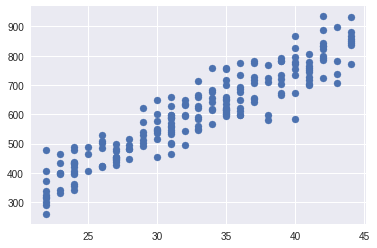

In [7]:
plt.scatter(df['age'], df['salary'])


In [0]:
def linear_regression(features):
    weight = ed.Normal(loc=tf.zeros(features.shape[1]), scale=300., name="weight")
    bias = ed.Normal(loc=0., scale=300., name="bias")
    scale = ed.Normal(loc=0, scale=300., name="scale")
    
    linear_predictor = weight*(features-22) + bias
    outcomes = ed.Normal(
        loc=linear_predictor,
        scale=scale,
        name="outcomes")
    
    return outcomes

features = tf.convert_to_tensor(X_data.reshape(-1, 1))
outcomes = tf.convert_to_tensor(Y_data.reshape(-1, 1))

In [0]:
log_joint = ed.make_log_joint_fn(linear_regression)
def target_log_prob_fn(weight, bias, scale):
    return log_joint(features=features, 
                     weight=weight, 
                     bias=bias, 
                     scale=scale,
                     outcomes=outcomes)

In [48]:
"""
weight_init = tf.random_normal([features.shape[1]])
bias_init = tf.random_normal([])
scale_init = tf.random_normal([])

target_log_prob_fn(weight_init, bias_init, scale_init)

shape:  ([1,] , [], [])
"""

'\nweight_init = tf.random_normal([features.shape[1]])\nbias_init = tf.random_normal([])\nscale_init = tf.random_normal([])\n\ntarget_log_prob_fn(weight_init, bias_init, scale_init)\n\nshape:  ([1,] , [], [])\n'

In [0]:
weight_init = tf.constant([20.])
bias_init = tf.constant(300.)
scale_init = tf.constant(10.)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    num_leapfrog_steps=3,
    step_size=tf.Variable(0.01),
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy())

    
[
    [weight, bias, scale],
    kernel_results,
] = tfp.mcmc.sample_chain(
        num_results=2000,
        num_burnin_steps=500,
        current_state=[weight_init, bias_init, scale_init],
        parallel_iterations=500,
        kernel=hmc)



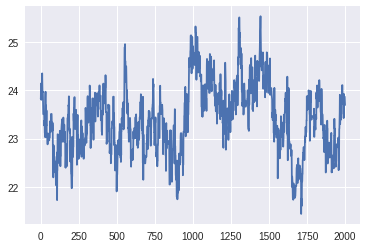

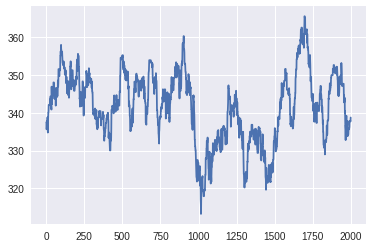

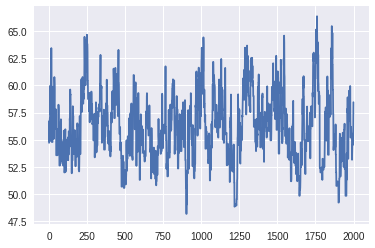

In [56]:
plt.figure()
plt.plot(weight.numpy())
plt.figure()
plt.plot(bias.numpy())
plt.figure()
plt.plot(scale.numpy())

In [0]:
def linear_predictor(feature, weight, bias):

    linear_predictor_ = tf.tensordot((feature-22), weight, [[1], [1]]) + bias
    outcomes = ed.Normal(
        loc=linear_predictor_,
        scale=scale,
        )
    
    return outcomes  
    

In [113]:
X_predict = np.arange(22, 60, 1).reshape(-1, 1).astype(np.float32)
y_samples = linear_predictor(X_predict, weight, bias)
y_samples = y_samples.numpy().transpose(1, 0)
y_samples.shape

(2000, 38)

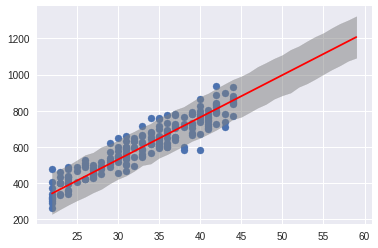

In [114]:
from scipy.stats import mstats

low_y, high_y = mstats.mquantiles(y_samples, [0.025, 0.975], axis=0)

plt.scatter(df["age"], df["salary"])
plt.fill_between(X_predict.reshape(-1), low_y, high_y, alpha=0.5, color="gray")

a_ = bias.numpy().mean()
b_ = weight.numpy().mean()
x_ = np.arange(22, 60, 1) 
y_ = a_ + b_ * (x_ - 22)
plt.plot(x_, y_, c='r')

ValueError: ignored